# FFT Batch processing GPU vs CPU performance - various image & batch sizes

In [11]:
import torch
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, List

plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.5.0a0+872d972e41.nv24.08
CUDA available: True
CUDA device: Orin
CUDA version: 12.6


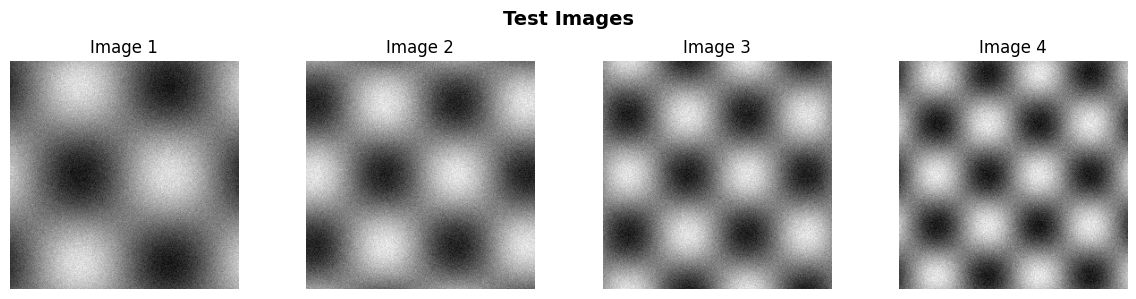

In [12]:
# generate test data
def generate_test_batch(batch_size: int, image_size: int) -> np.ndarray:
    batch = np.zeros((batch_size, image_size, image_size), dtype=np.float32)
    
    for i in range(batch_size):
        x = np.linspace(-2, 2, image_size)
        y = np.linspace(-2, 2, image_size)
        X, Y = np.meshgrid(x, y)
        
        freq = 2 + i * 0.5
        batch[i] = np.sin(freq * X) * np.cos(freq * Y)
        batch[i] += np.random.randn(image_size, image_size) * 0.1
    return batch

# visualization
test_batch = generate_test_batch(4, 256)
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow(test_batch[i], cmap='gray')
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.suptitle('Test Images', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
# FFT -> fftshift -> ifftshift -> IFFT
def benchmark_fft_pytorch(batch_tensor: torch.Tensor, device: str, n_runs: int = 5) -> float:
    batch_tensor = batch_tensor.to(device)
    
    # Warmup
    for _ in range(2):
        fft_result = torch.fft.fft2(batch_tensor)
        fft_shifted = torch.fft.fftshift(fft_result)
        _ = torch.fft.ifft2(torch.fft.ifftshift(fft_shifted))
    
    if device == 'cuda':
        torch.cuda.synchronize()
    
    start = time.time()
    for _ in range(n_runs):
        fft_result = torch.fft.fft2(batch_tensor)
        fft_shifted = torch.fft.fftshift(fft_result)
        _ = torch.fft.ifft2(torch.fft.ifftshift(fft_shifted))
    
    if device == 'cuda':
        torch.cuda.synchronize()
    
    return (time.time() - start) * 1000 / n_runs


def benchmark_fft_numpy(batch_np: np.ndarray, n_runs: int = 5) -> float:
    for _ in range(2): # wu
        fft_result = np.fft.fft2(batch_np)
        fft_shifted = np.fft.fftshift(fft_result)
        _ = np.fft.ifft2(np.fft.ifftshift(fft_shifted))
    
    start = time.time()
    for _ in range(n_runs):
        fft_result = np.fft.fft2(batch_np)
        fft_shifted = np.fft.fftshift(fft_result)
        _ = np.fft.ifft2(np.fft.ifftshift(fft_shifted))
    return (time.time() - start) * 1000 / n_runs

In [14]:
# config
image_sizes = [256, 512]
batch_sizes = [1, 10, 50, 100]

# memory estimation for GPU -- for feasibility. 
# ran into "notebook controller disposed" error using 1024
def estimate_gpu_memory_mb(batch_size, img_size):
    return batch_size * img_size * img_size * 8 * 3/(1024**2)

max_mem_mb = float('inf')
if torch.cuda.is_available():
    total_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"GPU Total Memory: {total_mem:.1f} GB")
    max_mem_mb = total_mem * 1024 * 0.5
    print(f"Max mem budget: {max_mem_mb:.0f} MB")

results = []
for img_size in image_sizes:
    for batch_size in batch_sizes:
        est_mem = estimate_gpu_memory_mb(batch_size, img_size)
        
        if torch.cuda.is_available() and est_mem > max_mem_mb:
            print(f"Size: {img_size}x{img_size}, Batch: {batch_size} - SKIPPED (memory)")
            continue
            
        print(f"Size: {img_size}x{img_size}, Batch: {batch_size}")
        
        batch_np = generate_test_batch(batch_size, img_size)
        batch_tensor = torch.from_numpy(batch_np).float()
        
        #NumPy
        numpy_time = benchmark_fft_numpy(batch_np, n_runs=3)
        
        # pytorch cpu
        cpu_time = benchmark_fft_pytorch(batch_tensor, 'cpu', n_runs=3)
        
        # PyTorch GPU
        gpu_time = None
        if torch.cuda.is_available():
            try:
                torch.cuda.empty_cache()
                gpu_time = benchmark_fft_pytorch(batch_tensor, 'cuda', n_runs=5)
                torch.cuda.empty_cache()
            except RuntimeError:
                pass
        
        results.append({
            'image_size': img_size,
            'batch_size': batch_size,
            'numpy_cpu_ms': numpy_time,
            'pytorch_cpu_ms': cpu_time,
            'pytorch_cuda_ms': gpu_time,
        })
        
        del batch_np, batch_tensor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

df = pd.DataFrame(results)
print("done!")

GPU Total Memory: 7.4 GB
Max mem budget: 3810 MB
Size: 256x256, Batch: 1
Size: 256x256, Batch: 10
Size: 256x256, Batch: 50
Size: 256x256, Batch: 100
Size: 512x512, Batch: 1
Size: 512x512, Batch: 10
Size: 512x512, Batch: 50
Size: 512x512, Batch: 100
done!


In [15]:
display(df)

,image_size,batch_size,numpy_cpu_ms,pytorch_cpu_ms,pytorch_cuda_ms
0,256,1,5.147378,4.125039,0.505495
1,256,10,58.373849,34.087658,4.213476
2,256,50,335.088332,182.605664,10.288715
3,256,100,664.296548,363.378604,19.989300
4,512,1,25.162458,13.590018,1.716900
5,512,10,294.903835,154.248794,8.980227
6,512,50,1439.613183,764.473279,39.510918
7,512,100,2879.207293,1508.448124,81.417322


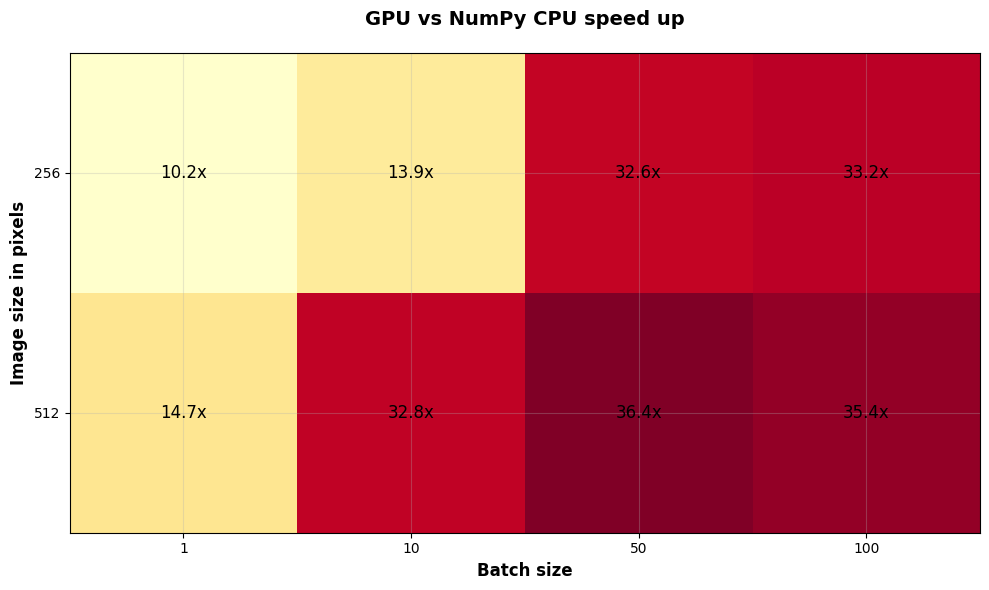

In [16]:
# Speedup heatmap (GPU vs NumPy baseline)
df_valid = df[df['pytorch_cuda_ms'].notna()].copy()
df_valid['speedup_vs_numpy'] = df_valid['numpy_cpu_ms'] / df_valid['pytorch_cuda_ms']

fig, ax = plt.subplots(figsize=(10, 6))
pivot = df_valid.pivot(index='image_size', columns='batch_size', values='speedup_vs_numpy')
im = ax.imshow(pivot.values, cmap='YlOrRd', aspect='auto')
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        val = pivot.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f'{val:.1f}x', ha='center', va='center', fontsize=12)

ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xlabel('Batch size', fontsize=12, fontweight='bold')
ax.set_ylabel('Image size in pixels', fontsize=12, fontweight='bold')
ax.set_title('GPU vs NumPy CPU speed up', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('speedup_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

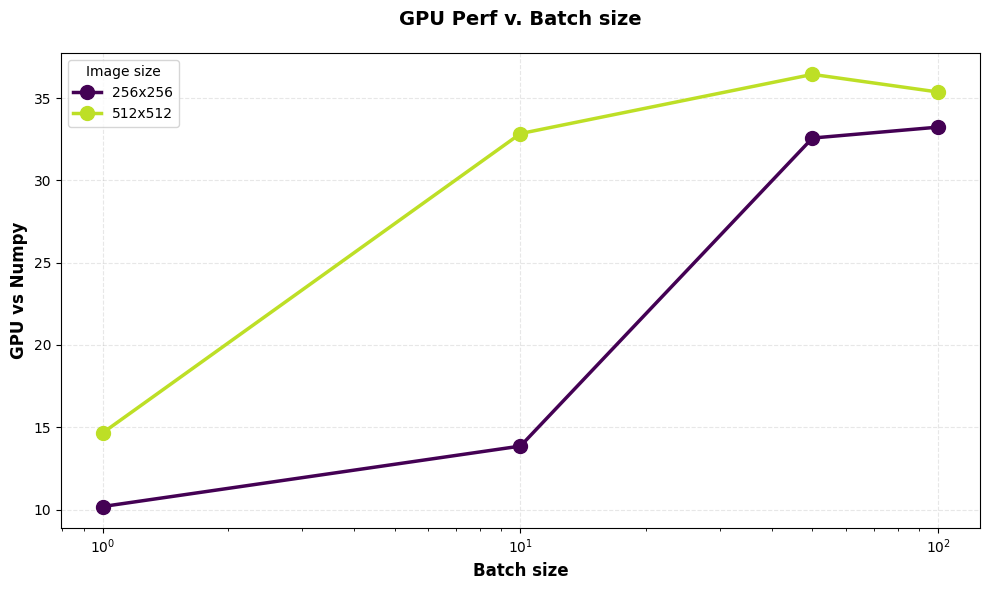

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 0.9, len(df_valid['image_size'].unique())))

for i, size in enumerate(sorted(df_valid['image_size'].unique())):
    data = df_valid[df_valid['image_size'] == size]
    ax.plot(data['batch_size'], data['speedup_vs_numpy'], 
            marker='o', linewidth=2.5, markersize=10, 
            label=f'{size}x{size}', color=colors[i])

ax.set_xlabel('Batch size', fontsize=12, fontweight='bold')
ax.set_ylabel('GPU vs Numpy', fontsize=12, fontweight='bold')
ax.set_title('GPU Perf v. Batch size', fontsize=14, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(title='Image size', fontsize=10)
plt.tight_layout()
plt.savefig('speedup_vs_batch.png', dpi=300, bbox_inches='tight')
plt.show()

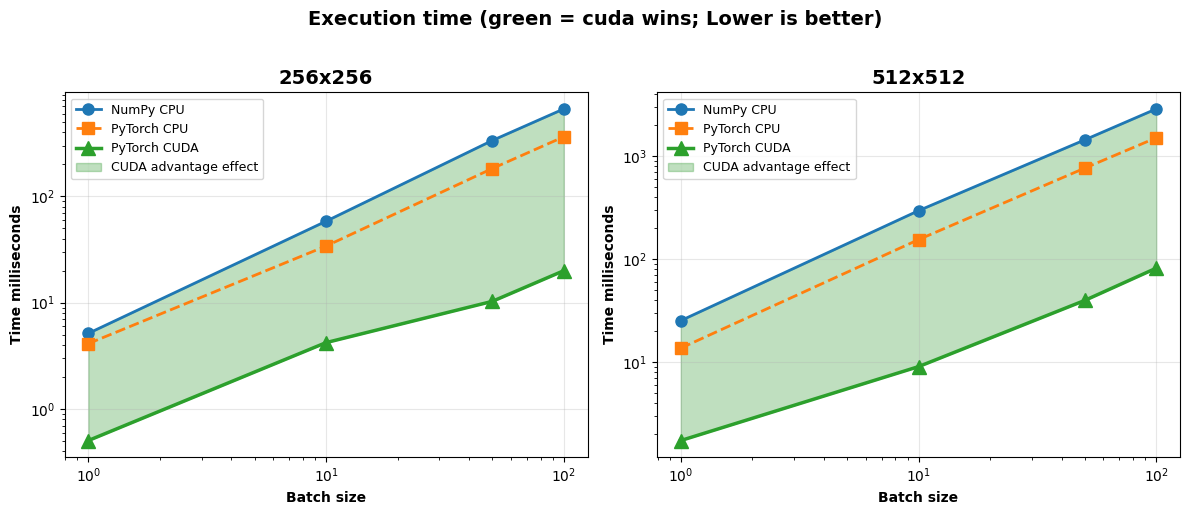

In [18]:
fig, axes = plt.subplots(1, len(df['image_size'].unique()), figsize=(6*len(df['image_size'].unique()), 5))
if len(df['image_size'].unique()) == 1:
    axes = [axes]

for ax, img_size in zip(axes, sorted(df['image_size'].unique())):
    data = df[df['image_size'] == img_size]
    ax.plot(data['batch_size'], data['numpy_cpu_ms'], 
            'o-', linewidth=2, markersize=8, label='NumPy CPU', color='#1f77b4')
    ax.plot(data['batch_size'], data['pytorch_cpu_ms'], 
            's--', linewidth=2, markersize=8, label='PyTorch CPU', color='#ff7f0e')
    if data['pytorch_cuda_ms'].notna().any():
        ax.plot(data['batch_size'], data['pytorch_cuda_ms'], 
                '^-', linewidth=2.5, markersize=10, label='PyTorch CUDA', color='#2ca02c')
        
        # shade region where CUDA is faster than NumPy
        ax.fill_between(data['batch_size'], 
                        data['pytorch_cuda_ms'], 
                        data['numpy_cpu_ms'],
                        alpha=0.25, color='green', 
                        label='CUDA advantage effect')
    
    ax.set_xlabel('Batch size', fontweight='bold')
    ax.set_ylabel('Time milliseconds', fontweight='bold')
    ax.set_title(f'{img_size}x{img_size}', fontweight='bold', fontsize=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Execution time (green = cuda wins; Lower is better)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('timing_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
df.to_csv('fft_benchmark_results.csv', index=False)
print("fft_benchmark_results.csv")

fft_benchmark_results.csv


In [20]:
summary_rows = []

for _, row in df.iterrows():
    config = f"{row['image_size']}x{row['image_size']}, batch={int(row['batch_size'])}"
    
    numpy_time = row['numpy_cpu_ms']
    pytorch_cpu = row['pytorch_cpu_ms']
    pytorch_cuda = row['pytorch_cuda_ms']
    
    cpu_speedup = numpy_time / pytorch_cpu if pytorch_cpu else None
    cuda_speedup = numpy_time / pytorch_cuda if pytorch_cuda else None
    
    summary_rows.append({
        'Config': config,
        'NumPy CPU (ms)': f"{numpy_time:.2f}",
        'PyTorch CPU (ms)': f"{pytorch_cpu:.2f}",
        'PyTorch CUDA (ms)': f"{pytorch_cuda:.2f}" if pytorch_cuda else "N/A",
        'CPU Speedup': f"{cpu_speedup:.2f}x" if cpu_speedup else "N/A",
        'CUDA Speedup': f"{cuda_speedup:.2f}x" if cuda_speedup else "N/A",
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

# Overall stats
print("notes")

if df['pytorch_cuda_ms'].notna().any():
    best_row = df.loc[(df['numpy_cpu_ms'] / df['pytorch_cuda_ms']).idxmax()]
    best_speedup = best_row['numpy_cpu_ms'] / best_row['pytorch_cuda_ms']
    print(f"best GPU speedup: {best_speedup:.1f}x @ {int(best_row['image_size'])}x{int(best_row['image_size'])}, batch={int(best_row['batch_size'])}")
    
    avg_cuda_speedup = (df['numpy_cpu_ms'] / df['pytorch_cuda_ms']).mean()
    print(f"avg GPU speedup: {avg_cuda_speedup:.1f}x")

avg_cpu_speedup = (df['numpy_cpu_ms'] / df['pytorch_cpu_ms']).mean()
print(f"avg PyTorch CPU speedup: {avg_cpu_speedup:.2f}x")

,Config,NumPy CPU (ms),PyTorch CPU (ms),PyTorch CUDA (ms),CPU Speedup,CUDA Speedup
0,"256.0x256.0, batch=1",5.15,4.13,0.51,1.25x,10.18x
1,"256.0x256.0, batch=10",58.37,34.09,4.21,1.71x,13.85x
2,"256.0x256.0, batch=50",335.09,182.61,10.29,1.84x,32.57x
3,"256.0x256.0, batch=100",664.30,363.38,19.99,1.83x,33.23x
4,"512.0x512.0, batch=1",25.16,13.59,1.72,1.85x,14.66x
5,"512.0x512.0, batch=10",294.90,154.25,8.98,1.91x,32.84x
6,"512.0x512.0, batch=50",1439.61,764.47,39.51,1.88x,36.44x
7,"512.0x512.0, batch=100",2879.21,1508.45,81.42,1.91x,35.36x


notes
best GPU speedup: 36.4x @ 512x512, batch=50
avg GPU speedup: 26.1x
avg PyTorch CPU speedup: 1.77x
